In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh
# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [1]:
# reload(sdh)

In [2]:
# reload(nn)
import relembed as nn

In [54]:
# reload(eh)
import experiment_helper as eh

In [4]:
shuffle_seed = 10

In [7]:
# reload(dh)
DH = dh.DataHandler('data/semeval_train_sent_8000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
7999 total examples :: 7199 training : 800 valid (90:10 split)
Vocab size: 22683 Dep size: 50


In [8]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=True, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [9]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

[[2402, 249], [283, 2652], [7831, 4618], [3648, 7100], [8053, 1784]]


In [10]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [11]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM

19423 / 22683 pretrained


In [12]:
def reset_drnn(model_name='relembed', dep_embed_size=25, word_embed_size=None, max_grad_norm=3.):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'bidirectional':True,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'bidirectional':True,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [13]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [14]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

# Unsupervised Training

In [ ]:
# hyperparameters
num_epochs = 1
batch_size =50
neg_per = 25
num_nearby = 50
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

In [ ]:
drnn.checkpoint()

In [ ]:
# # test the embeddings

# ### VALID ###
# # valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
# # phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
# # phrase_labels, target_labels = DH.readable_data(valid=True)

# ### TRAIN ###
# train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
# phrase_labels, target_labels = DH.readable_data(show_dep=False, valid=False)
        
# phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
# target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

In [ ]:
# ### JOINT ###
# start = 0
# stride = 40
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
# joint_2d = lowd.fit_transform(joint_embeds)
# phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### PHRASE ONLY ###
# start = 0
# stride = 50
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### TARGET ONLY ###
# start = 0
# stride = 35
# end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# target_2d = lowd.fit_transform(target_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
### TW2V demo ###
start = 200
stride = 100
end = start + stride

lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
# lowd = PCA(n_components=2)

target_2d = lowd.fit_transform(word_embeddings[start:end])

fig, ax = plt.subplots(figsize=(28,16))
for i, label in enumerate(DH.vocab[start:end]):
    label = "%s" % (label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    
plt.savefig('word2vec_demo.png', dpi=200)

# Test out semeval data

In [12]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [13]:
for i, (raw, _, sdp, target, label) in enumerate(zip_train):
    if i > 5:
        break
    print(raw)
    print("%s :: %s" % (DH.sequence_to_sentence(sdp, show_dep=True), DH.sequence_to_sentence(target)))
    print(int2label[label])
    print("="*80)


4046	"The <e1>grief</e1> from sudden <e2>death</e2> is completely different from expected death, when families have time to prepare and say goodbye."

(grief, nsubj) (from, prep) (death, pobj) :: grief death
Cause-Effect(e2,e1)
5297	"The author examines some <e1>issues</e1> connected to religious <e2>freedom</e2>."

(issues, dobj) (connected, acl) (to, prep) (freedom, pobj) :: issues freedom
Other
5275	"The <e1>lawsuit</e1> alleged the release of the records was a <e2>violation</e2> of the Video Privacy Protection Act."

(lawsuit, nsubj) (alleged, ROOT) (was, ccomp) (violation, attr) :: lawsuit violation
Message-Topic(e1,e2)
6524	"This movie has thrown <e1>viewers</e1> into <e2>confusion</e2>."

(viewers, dobj) (thrown, ROOT) (into, prep) (confusion, pobj) :: viewers confusion
Other
5981	"The <e1>windshield</e1> encloses a parachute <e2>housing</e2> containing a parachute assembly."

(windshield, nsubj) (encloses, ROOT) (housing, dobj) :: windshield housing
Content-Container(e2,e1)
369

# Supervised Training

In [159]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 50
display_mod = 10
valid_mod = 50
print("Num steps %i" %num_steps)

best_valid = 1000000
best_model = None

start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            if valid_xent < best_valid:
                best_valid = valid_xent
                print("New best")
                best_model = drnn.checkpoint()
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
    print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    valid_xent = drnn.validation_class_loss(*valid_batch)
    m,s = divmod(time()-start, 60)
    h,m = divmod(m, 60)
    print("="*80)
    print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
    print("="*80)
    if valid_xent < best_valid:
        best_valid = valid_xent
        print("New best")
        best_model = drnn.checkpoint()
print("Done")

Num steps 143
(0:0:0) s 0/143, e 0 avg class xent loss = 2.9375
(0:0:1) s 0/143, e 0 validation avg class xent loss = 2.9028
New best
Saving model to file: checkpoints/relembed_semeval_alt_hidden.ckpt-0-1
(0:0:9) s 10/143, e 0 avg class xent loss = 2.7254
(0:0:12) s 20/143, e 0 avg class xent loss = 2.4200
(0:0:15) s 30/143, e 0 avg class xent loss = 2.1910
(0:0:17) s 40/143, e 0 avg class xent loss = 2.2155
(0:0:20) s 50/143, e 0 avg class xent loss = 1.7988
(0:0:21) s 50/143, e 0 validation avg class xent loss = 1.8658
New best
Saving model to file: checkpoints/relembed_semeval_alt_hidden.ckpt-0-51
(0:0:28) s 60/143, e 0 avg class xent loss = 1.5601
(0:0:31) s 70/143, e 0 avg class xent loss = 1.8176
(0:0:34) s 80/143, e 0 avg class xent loss = 1.5774
(0:0:36) s 90/143, e 0 avg class xent loss = 1.3412
(0:0:39) s 100/143, e 0 avg class xent loss = 1.6330
(0:0:40) s 100/143, e 0 validation avg class xent loss = 1.3677
New best
Saving model to file: checkpoints/relembed_semeval_alt_hid

KeyboardInterrupt: 

In [168]:
drnn.restore(best_model)

# Alternating

In [172]:
results = []
#timing stuff
start = time()
fit_time = 0
nearby_time = 0

batch_size = 50
num_cycles = 20
num_epochs = 3
num_class_epochs = 5
display_mod = 10
valid_mod = 50

# hyperparameters

neg_per = 15
neg_level = 2
num_nearby = 20
nearby_mod = 100
sample_power = .75
DH.scale_vocab_dist(sample_power)

# # bookkeeping
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

    
for cycle in range(num_cycles):
    print("+"*80)
    print("+++ CYCLE %i +++" % cycle)
    print("+"*80)

    epoch = 0
    class_epoch = 0
    
    num_steps = DH.num_steps(batch_size)


    for epoch in range(num_epochs):
        print("="*80)
        print("=== UNSUP EPOCH %i ===" % epoch)
        print("="*80)
        offset = 0 #if epoch else 400
        DH.shuffle_data()
        for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per, neg_level=neg_level)):
            if not step: step = offset
            t0 = time()
            loss = drnn.partial_unsup_fit(*batch)
            fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
            if step % display_mod == 0:
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
                ml,sl = divmod(left, 60)
                hl,ml = divmod(ml, 60)
                pps = batch_size*(neg_per + 1) / fit_time 
                print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                      % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
            if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
                t0 = time()
                run_validation_test(num_nearby) # check out the nearby phrases in the validation set
                valid_loss = drnn.validation_loss(*DH.validation_batch())
                print("Validation loss: %0.4f" % valid_loss)
                nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
            total_step +=1
        valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
        print("Saving model...")
        model_file = drnn.checkpoint()
        result = {'cycle':cycle, 'unsup_epoch':epoch, 'class_epoch':class_epoch, 
              'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
        results.append(result)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))

    num_steps = len(train['labels']) // batch_size

    for class_epoch in range(num_class_epochs):
    #     class_batch = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=0)
    #     random.shuffle(class_batch)
        print("*"*80)
        print("*** CLASS EPOCH %i ***" % class_epoch)
        print("*"*80)
        for class_step in range(num_steps):
            inputs, targets, labels, lens = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=class_step)
            class_batch = zip(inputs, targets, labels, lens)
            random.shuffle(class_batch)
            class_batch = zip(*class_batch)
            xent = drnn.partial_class_fit(*class_batch)
            if class_step % display_mod == 0:   
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, xent))
            if class_step % valid_mod == 0:
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                valid_xent = drnn.validation_class_loss(*valid_batch)
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("="*80)
                print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, valid_xent))
                print("="*80)
                
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
        print("Saving model...")
        model_file = drnn.checkpoint()
        result = {'cycle':cycle, 'unsup_epoch':epoch, 'class_epoch':class_epoch, 
              'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
        results.append(result)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    print("Done")
best = sorted(results, key=lambda x:x['macro_f1'], reverse=True)[0]
print("Best result %2.4f, C:%i, UE:%i, CE:%i" % 
      (best['macro_f1'], best['cycle'], best['unsup_epoch'], best['class_epoch']))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++ CYCLE 0 +++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
=== UNSUP EPOCH 0 ===
(0:0:2) step 0/143, epoch 0 Training Loss = 788.02313 :: 892.463 phrases/sec :: (0:6:22) hours left
Top 20 closest phrases to <cracks> 'cracks caused by earthquakes' <earthquakes>
0: 1.000 : <cracks> 'cracks caused by earthquakes' <earthquakes>
1: 0.744 : <slides> 'slides caused by earthquake' <earthquake>
2: 0.714 : <damages> 'damages caused by mudslides tremors' <tremors>
3: 0.535 : <devastation> 'devastation caused by asteroid' <asteroid>
4: 0.525 : <crisis> 'crisis caused by flood' <flood>
5: 0.506 : <damage> 'damage caused by crisis' <crisis>
6: 0.502 : <hull> 'hull caused scratch' <scratch>
7: 0.491 : <explosion> 'explosion caused leak gas' <gas>
8: 0.489 : <damage> 'damage caused by destruction' <destruction>
9: 0.472 : <prices> 'prices caused collapse' <collapse>
10: 0.459 : <flows

KeyboardInterrupt: 

In [39]:
print(best['model'])

checkpoints/relembed_semeval_alt.ckpt-286-286


In [160]:
# write out the training and validation keys for our split
with open('SemEval2010_task8_all_data/train_keys.txt', 'w') as f:
    i = 1
    for label in train['labels']:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1
with open('SemEval2010_task8_all_data/valid_keys.txt', 'w') as f:
    i = len(train['labels'])
    for label in valid['labels']:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1

In [161]:
# check out training predictions
valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])

# valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3], return_probs=False)
# write out to file and get official score
with open('SemEval2010_task8_all_data/train_preds.txt', 'w') as f:
    i = 1
    for label in preds:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1


In [162]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/train_preds.txt SemEval2010_task8_all_data/train_keys.txt;

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 306    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    1    0    1 |  309    0  309
 C-E2 |   1  597    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  598    0  598
 C-W1 |   0    0  428    1    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0 |  430    0  430
 C-W2 |   0    0    0  425    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0 |  426    0  426
 C-C1 |   0    0    0    0  333    1    2    0    0    0    0    0    0    0    0    0    0    0    2 |  338    0  338
 C-C2 |   0    0    1    0    0  147    0    0    0    0    0    0    0    0    0    0   

In [163]:
# check out validation predictions
# valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])

valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3], return_probs=False)
# write out to file and get official score
with open('SemEval2010_task8_all_data/valid_preds.txt', 'w') as f:
    i = len(train['labels'])
    for label in preds:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1


In [164]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/valid_preds.txt SemEval2010_task8_all_data/valid_keys.txt;

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |  28    3    0    0    0    0    0    0    0    0    0    0    0    0    0    1    1    2 |   35    0   35
 C-E2 |   1   53    1    0    0    0    0    1    0    0    0    0    0    0    0    1    0    4 |   61    0   61
 C-W1 |   0    0   33    2    0    0    0    0    1    0    1    0    2    0    0    0    0    1 |   40    0   40
 C-W2 |   0    0    2   33    0    2    0    0    1    0    3    0    0    0    1    0    0    3 |   45    0   45
 C-C1 |   0    0    2    0   28    0    4    0    0    0    0    0    0    0    0    0    0    2 |   36    0   36
 C-C2 |   0    0    0    1    0   14    0    0    0    0    0    0    0    0    0    0    0    3 |   18    0   18
 E-D1 |   

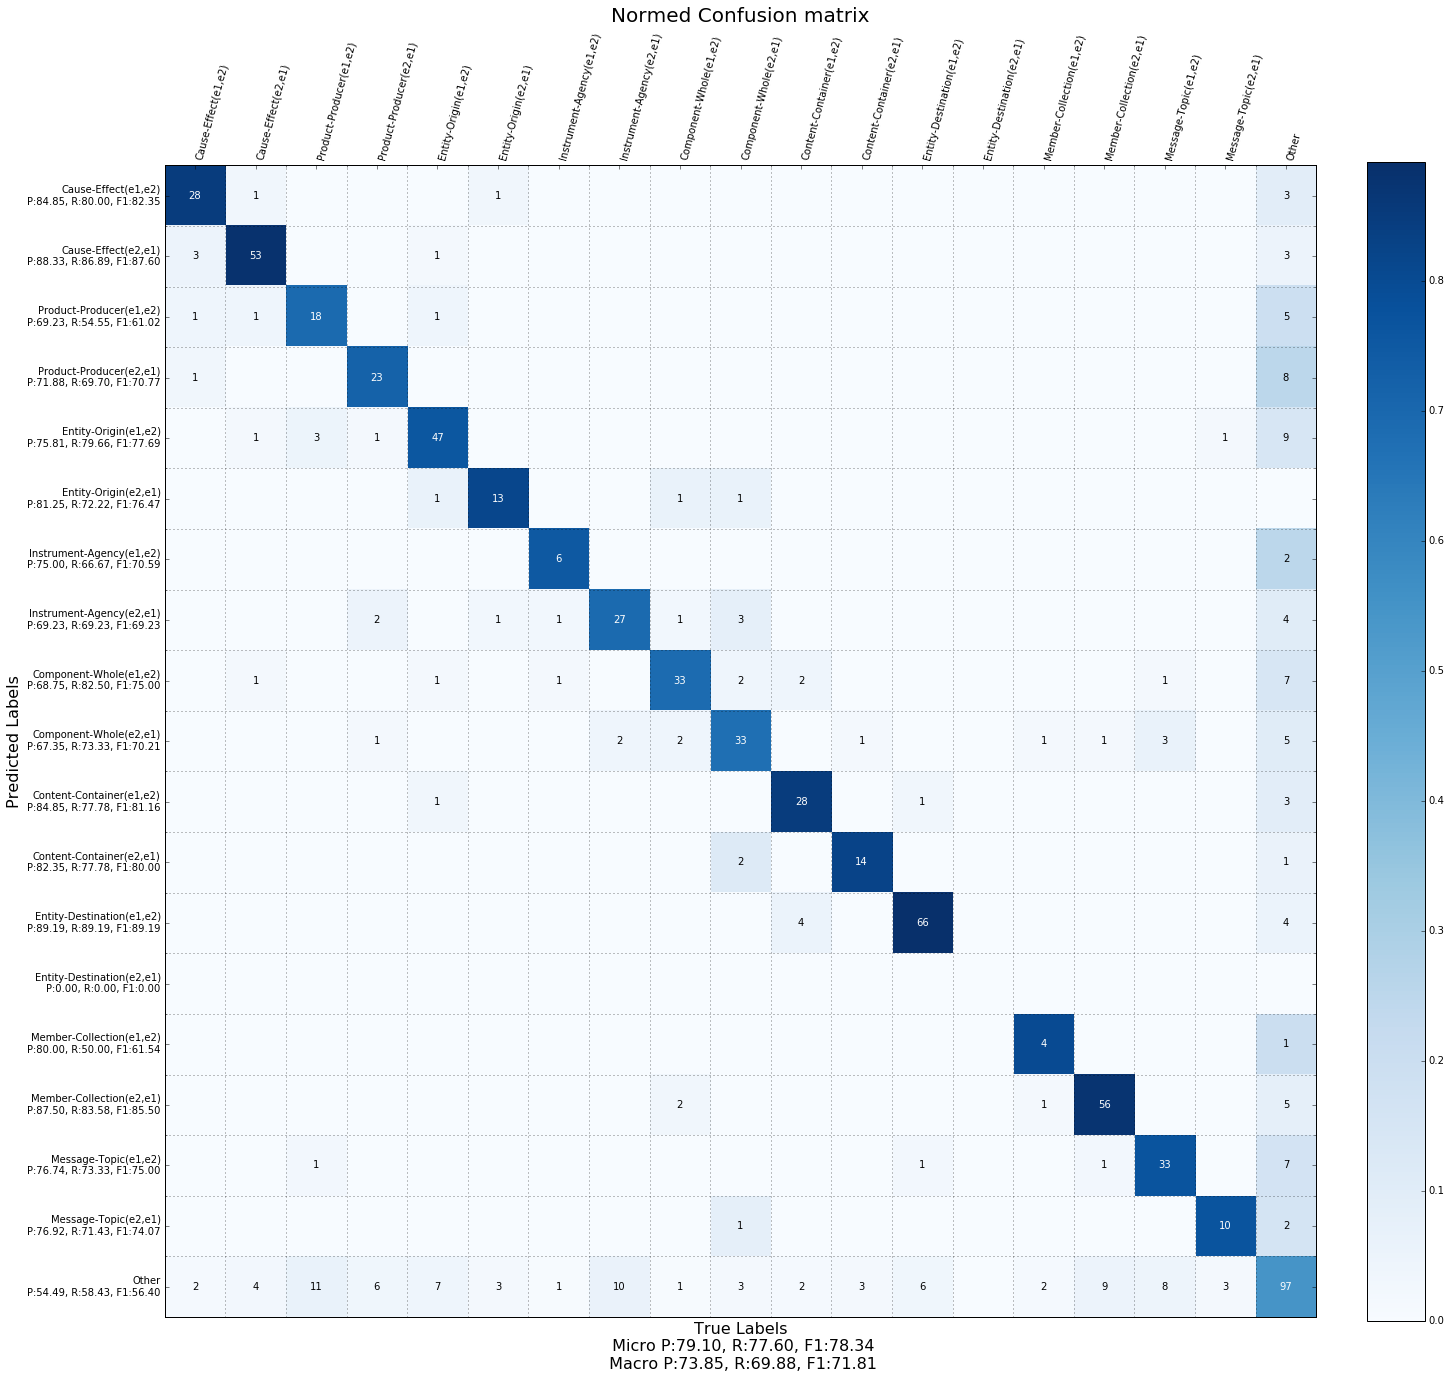

In [165]:
# save_name = raw_input("Enter save name: ")
save_name = ''
cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set, no_other=True)
eh.plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

In [169]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [170]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 117    6    1    2    0    0    0    0    0    0    0    0    0    0    0    1    0    0    7 |  134    0  134
 C-E2 |   2  172    0    0    0    0    0    0    3    0    0    1    0    0    0    0    3    0   13 |  194    0  194
 C-W1 |   0    0  115   11    5    0    0    0    0    1    0    0    3    8    2    0    0    0   17 |  162    0  162
 C-W2 |   0    0    5  113    1    3    0    0    1    0    0    5    1    2    4    1    0    1   13 |  150    0  150
 C-C1 |   0    0    0    0  137    4    4    0    2    0    0    0    0    0    0    0    0    0    6 |  153    0  153
 C-C2 |   0    0    0    3    1   33    0    0    0    1    0    0    0    0    0    0   

In [ ]:
# for i, p in enumerate(preds):
#     print("%i, pred: %s, true: %s" %(i, int2label[p], int2label[valid['labels'][i]]))
#     taarget = DH.sequence_to_sentence(valid['targets'][i]).split(' ')
#     sdp = DH.sequence_to_sentence(valid['sdps'][i], show_dep=True)
#     print('<%s> "%s" <%s>' % (target[0], sdp, target[1]))
#     print(valid['raws'][i])
#     print(valid['comments'][i])
#     print("="*80)

### Directional Evaluation

In [ ]:
# save_name = raw_input("Enter save name: ")
save_name = ''
cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
eh.plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

### Non Directional evaluation

In [52]:
bi_preds, bi_int2label, bi_label2int = eh.directional_to_bidirectional_labels(preds, int2label)
bi_labels, _, _ = eh.directional_to_bidirectional_labels(valid['labels'], int2label)
bi_labelset = set(bi_int2label.keys())
print(bi_label2int)

{'Instrument-Agency': 0, 'Component-Whole': 5, 'Cause-Effect': 3, 'Entity-Destination': 4, 'Entity-Origin': 1, 'Member-Collection': 6, 'Other': 9, 'Content-Container': 7, 'Message-Topic': 8, 'Product-Producer': 2}


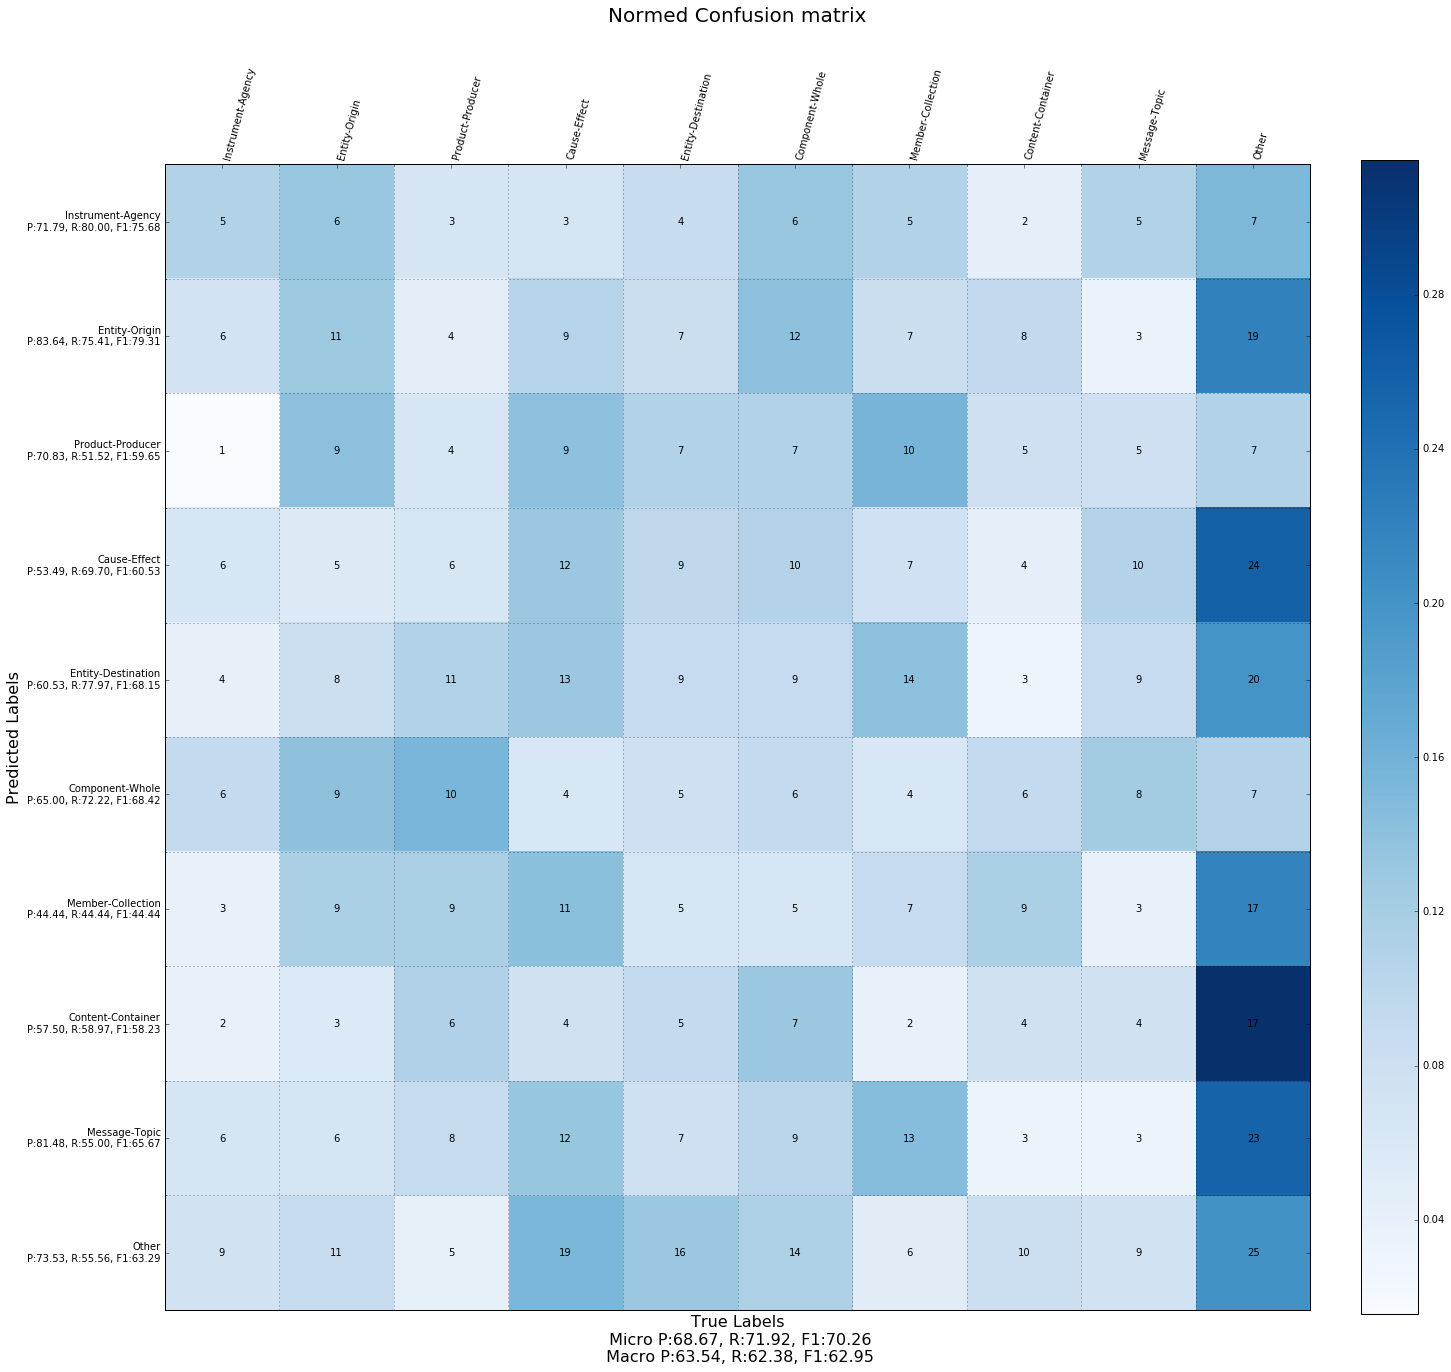

In [53]:
# save_name = raw_input("Enter save name: ")
bi_cm, bi_stats = eh.confusion_matrix(bi_preds, bi_labels, bi_labelset)
eh.plot_confusion_matrix(bi_cm, bi_int2label.values(), save_name=save_name, stats=stats)

In [ ]:
random.seed(42)
random.shuffle([0,1,2])

In [55]:
softmax = drnn._softmax_w.eval()
print(softmax)

[[ 0.15046783 -0.07926381 -0.07139096 ...,  0.15530533  0.15528928
  -0.03489654]
 [ 0.04042228  0.09538872 -0.0234619  ..., -0.11578997 -0.03041737
   0.09872109]
 [ 0.00355989  0.04355323  0.01314505 ..., -0.08976248  0.03831869
  -0.02159637]
 ..., 
 [ 0.07650714  0.1116127  -0.19541924 ..., -0.06763104 -0.00640409
  -0.10253665]
 [ 0.24079557  0.02183999  0.08162959 ...,  0.05062705  0.02412001
   0.05942392]
 [ 0.04069701  0.18276833 -0.29425266 ...,  0.04484601 -0.00119973
  -0.05428093]]


In [ ]:
eh.plot_confusion_matrix(softmax, int2label.values())

In [39]:
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds, dists = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3], return_probs=True)

In [111]:
def plot_probs(dists, labels, int2label):
    """Plot the predicted distributions as small multiples

    Args:
        dists: list of pmfs, all the same size
        int2label: dict of ints to labels for pmfs
    """
    fig, axarr = plt.subplots(len(dists)/2 + 1, 2, sharex=True, figsize=(16, 3*len(dists)))
    xticks = range(len(int2label.keys()))
    for i, dist in enumerate(dists):
        axarr[i/2, i%2].stem(dist)
        axarr[i/2, i%2].set_xlim([-1,19])
        axarr[i/2, i%2].set_xticks(xticks)
#         if i % 3 == 0 and i:
        axarr[i/2, i%2].set_xticklabels(int2label.values(), rotation=45, horizontalalignment="right", x=1)
        axarr[i/2, i%2].set_title(int2label[labels[i]])
    plt.tight_layout()

(1, 15, 14, 5, 16, 18, 18, 18, 2, 3)


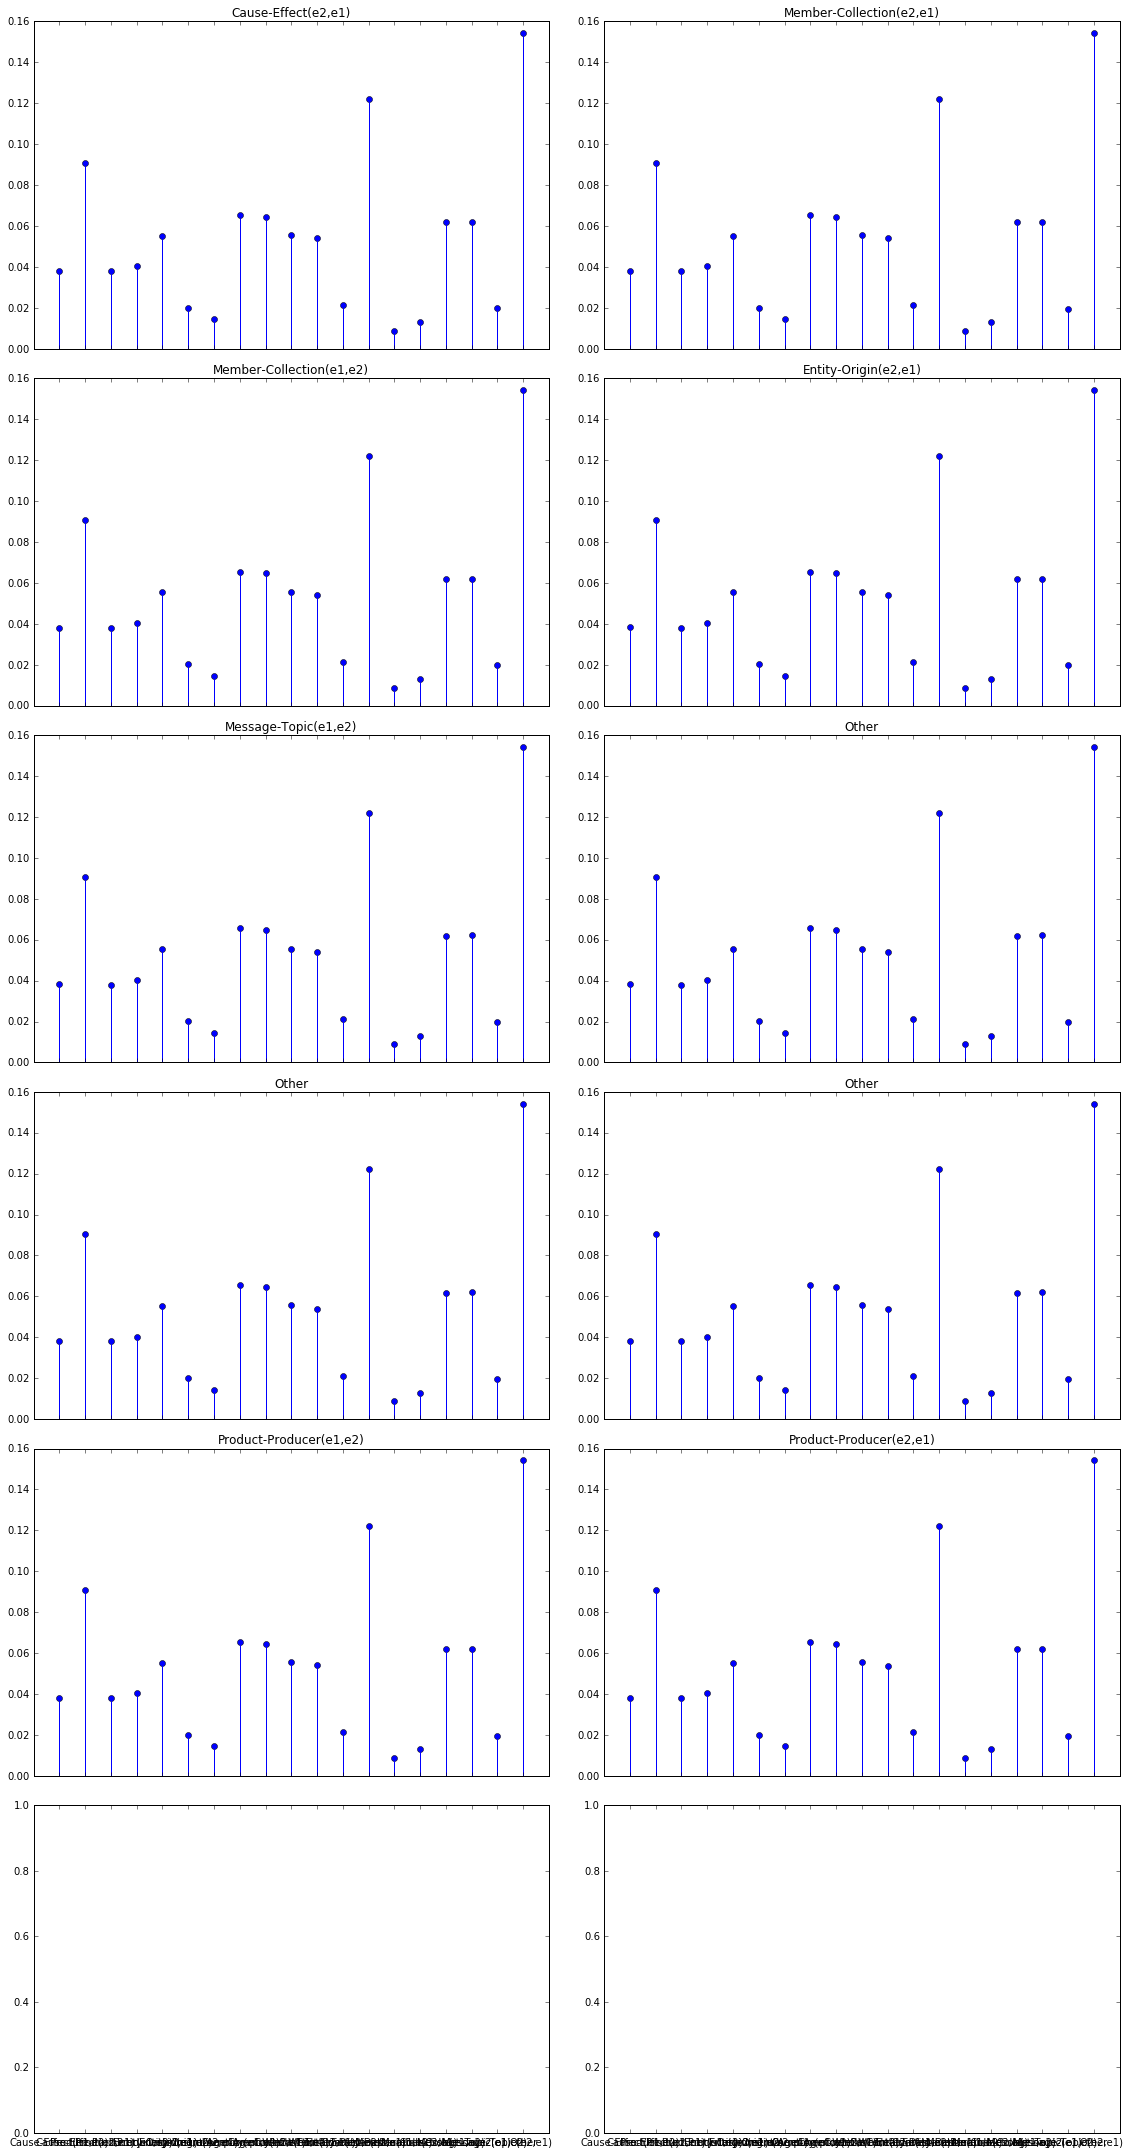

In [112]:
num = 10
small_dists, small_labels = dists[:num], valid['labels'][:num]
print(small_labels)
plot_probs(small_dists, small_labels, int2label)

### Active Learning Experiment


In [20]:
def alternating_fit(drnn, DH, train, valid, label_set, unsup_epochs=1, class_epochs=5, 
                    stop_tol=5, batch_size=50, neg_per=10, unsup=True):
    results = []
    #timing stuff
    start = time()
    fit_time = 0
    nearby_time = 0

    display_mod = 10
    valid_mod = 50

    # hyperparameters

    neg_level = 2
    num_nearby = 20
    nearby_mod = 100
    sample_power = .75
    DH.scale_vocab_dist(sample_power)

    # # bookkeeping
    total_step = 1
    save_interval = 30 * 60 # half hour in seconds
    save_time = time()

    best_valid = 1e1000
    after_best_count = 0
    
    class_batch_size = min(batch_size, len(train['labels']))
    
    cycle = 0
    total_unsup_count = 0
    total_class_count = 0
    while after_best_count < stop_tol:
        print("+"*80)
        print("+++ CYCLE %i +++" % cycle)
        print("+"*80)

        epoch = 0
        class_epoch = 0
        total_step = 0

        num_steps = DH.num_steps(batch_size)
        if unsup:
            for epoch in range(unsup_epochs):
                print("="*80)
                print("=== UNSUP EPOCH %i ===" % epoch)
                print("="*80)
                DH.shuffle_data()
                for step , batch in enumerate(DH.batches(batch_size, neg_per=neg_per, neg_level=neg_level)):
                    t0 = time()
                    loss = drnn.partial_unsup_fit(*batch)
                    fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
                    if step % display_mod == 0:
                        m,s = divmod(time()-start, 60)
                        h,m = divmod(m, 60)
                        left = time_left(unsup_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
                        ml,sl = divmod(left, 60)
                        hl,ml = divmod(ml, 60)
                        pps = batch_size*(neg_per + 1) / fit_time 
                        print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                              % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
                    if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
                        t0 = time()
                        run_validation_test(num_nearby) # check out the nearby phrases in the validation set
                        valid_loss = drnn.validation_loss(*DH.validation_batch())
                        print("Validation loss: %0.4f" % valid_loss)
                        nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
                    total_step +=1
                total_unsup_count +=1
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
                cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
                print("Saving model...")
                model_file = drnn.checkpoint()
                result = {'cycle':cycle, 'unsup_epoch':total_unsup_count, 'class_epoch':total_class_count, 
                      'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
                results.append(result)
                print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))

        
        num_steps = len(train['labels']) // class_batch_size

        for class_epoch in range(class_epochs):
            # shuffle training
            print("*"*80)
            print("*** CLASS EPOCH %i ***" % class_epoch)
            print("*"*80)
            for class_step in range(num_steps):
                inputs, targets, labels, lens = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=class_step)
                class_batch = zip(inputs, targets, labels, lens)
                random.shuffle(class_batch)
                class_batch = zip(*class_batch)
                xent = drnn.partial_class_fit(*class_batch)
                if class_step % display_mod == 0:   
                    m,s = divmod(time()-start, 60)
                    h,m = divmod(m, 60)
                    print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, xent))
            # measure validation performance
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, valid_xent))
            print("="*80)
            after_best_count += 1 # number of times since last best
            if valid_xent < best_valid:
                print("New Best!")
                best_valid = valid_xent
                after_best_count = 0
                best_model = drnn.checkpoint()
            
            preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
            cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
            print("Saving model...")
            model_file = drnn.checkpoint()
            result = {'cycle':cycle, 'unsup_epoch':total_unsup_count, 'class_epoch':total_class_count, 
                  'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
            results.append(result)
            print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
            total_class_count += 1
        cycle += 1
    best = sorted(results, key=lambda x:x['macro_f1'], reverse=True)[0]
    print("Best result %2.4f, C:%i, UE:%i, CE:%i" % 
          (best['macro_f1'], best['cycle'], best['unsup_epoch'], best['class_epoch']))  
    drnn.restore(best['model'])
    return drnn, results

In [21]:
from scipy.stats import entropy
label_set = set(train['labels'])
meta_results = []
drnn = reset_drnn()
N = 500
# first N examples
small_train = {k:v[:N] for k,v in train.items()}
rest_train = {k:v[N:] for k,v in train.items()}

# fit until early_stop on limited training
meta_batch_num = 0
while len(small_train['labels']) < len(train['labels']):
    print("%"*80)
    print("%i labeled so far (meta_cycle: %i, N: %i)" % (len(small_train['labels']), meta_batch_num, N))
    print("%"*80)

    drnn, results = alternating_fit(drnn, DH, small_train, valid, label_set, neg_per=20)
    meta_results.append({'N':N, 'results':results})

    # get all of the predictive distributions for the unknowns
    query_batch = DH.classification_batch(len(rest_train['labels']),
                                          rest_train['sdps'], 
                                          rest_train['targets'],
                                          rest_train['labels'])
    _, dists = drnn.predict(query_batch[0], query_batch[1], query_batch[3], return_probs=True)

    # rank based on highest entropy
    # then turn back into rest_train.values() style
    ranked_train = zip(*sorted(zip(dists, *rest_train.values()), key=lambda x:entropy(x[0]), reverse=True))

    # if we're at the very end we may need to make N smaller
    if len(small_train['labels']) + N >= len(train['labels']):
            N = len(train['labels']) - len(small_train['labels']) 
            # this should be same as what's left of rest
            assert N == len(rest_train['labels']), "Hm..."
    # skim off top N unknowns to train with and leave the rest as before
    small_train = {k:list(v)+list(ranked_train[i+1])[:N] for i,(k,v) in enumerate(small_train.items())}
    rest_train = {k:list(ranked_train[i+1])[N:] for i,(k,v) in enumerate(small_train.items())}
    meta_batch_num += 1
print("Done...")

<DPNN: W:300, D:25, H:600, V:22683>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
500 labeled so far (meta_cycle: 0, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++ CYCLE 0 +++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
=== UNSUP EPOCH 0 ===
(0:0:2) step 0/143, epoch 0 Training Loss = 788.44720 :: 497.674 phrases/sec :: (0:4:59) hours left
Top 20 closest phrases to <carafe> '<X> of <Y>' <water>
0: 1.000 : <maze> '<X> of <Y>' <canyons>
1: 1.000 : <leap> '<X> of <Y>' <leopards>
2: 1.000 : <stick> '<X> of <Y>' <plunger>
3: 1.000 : <spindle> '<X> of <Y>' <machine>
4: 1.000 : <backpage> '<X> of <Y>' <newspaper>
5: 1.000 : <blush> '<X> of <Y>' <boys>
6: 1.000 : <lead> '<X> of <Y>' <foxes>
7: 1.000 : <lining> '<X> of <Y>' <jacket>
8: 1.000 : <draught> '<X> of <Y>' <salmons>
9: 1.000 : <body> '<X> 

In [ ]:
###### Supervised only
from scipy.stats import entropy
label_set = set(train['labels'])
sup_meta_results = []
drnn = reset_drnn(model_name='sup')
N = 500
# first N examples
small_train = {k:v[:N] for k,v in train.items()}
rest_train = {k:v[N:] for k,v in train.items()}

# fit until early_stop on limited training
meta_batch_num = 0
while len(small_train['labels']) < len(train['labels']):
    print("%"*80)
    print("%i labeled so far (meta_cycle: %i, N: %i)" % (len(small_train['labels']), meta_batch_num, N))
    print("%"*80)

    drnn, results = alternating_fit(drnn, DH, small_train, valid, label_set, neg_per=20, unsup=False)
    sup_meta_results.append({'N':N, 'results':results})

    # get all of the predictive distributions for the unknowns
    query_batch = DH.classification_batch(len(rest_train['labels']),
                                          rest_train['sdps'], 
                                          rest_train['targets'],
                                          rest_train['labels'])
    _, dists = drnn.predict(query_batch[0], query_batch[1], query_batch[3], return_probs=True)

    # rank based on highest entropy
    # then turn back into rest_train.values() style
    ranked_train = zip(*sorted(zip(dists, *rest_train.values()), key=lambda x:entropy(x[0]), reverse=True))

    # if we're at the very end we may need to make N smaller
    if len(small_train['labels']) + N >= len(train['labels']):
            N = len(train['labels']) - len(small_train['labels']) 
            # this should be same as what's left of rest
            assert N == len(rest_train['labels']), "Hm..."
    # skim off top N unknowns to train with and leave the rest as before
    small_train = {k:list(v)+list(ranked_train[i+1])[:N] for i,(k,v) in enumerate(small_train.items())}
    rest_train = {k:list(ranked_train[i+1])[N:] for i,(k,v) in enumerate(small_train.items())}
    meta_batch_num += 1
print("Done...")

In [22]:
def best_f1(results):
    return sorted(results, key=lambda x:x['macro_f1'], reverse=True)[0]['macro_f1']

unsup_f1s = [best_f1(results['results']) for results in meta_results]
sup_f1s = [best_f1(results['results']) for results in sup_meta_results]
print(unsup_f1s)

[35.77092792008601, 40.903327899528904, 40.184616603315611, 42.828087478680921, 45.500837558407071, 50.524351179145924, 52.441974265678851, 55.978156752465424, 61.667893701804303, 60.855944871307535, 63.317702171080384, 64.32335450470562, 63.838391216692024, 63.11068733271815]


In [326]:
print(train.keys())
print(train['sents'][0][0].text)

['raws', 'sdps', 'labels', 'comments', 'sents', 'targets']
The grief from sudden death is completely different from expected death , when families have time to prepare and say goodbye .


### Ngram lositic regression baseline on full sentence

In [24]:
from sklearn.pipeline import Pipeline
# define baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Feature Extractors
cv = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents='unicode', 
        lowercase=True,
        analyzer=u'word', 
        preprocessor=None, 
        tokenizer=None, 
        stop_words='english', 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 2), 
        max_df=.9, 
        min_df=2, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=False
)

# Final Classifier
lr = LogisticRegression(C=.05,
                        fit_intercept=True,
                        random_state=0,
                        class_weight='balanced',
                        multi_class='multinomial',
                        solver='lbfgs',
                        n_jobs=-1)

pipeline = Pipeline([
    ('count', cv),
    ('tfidf', tf),
    ('logreg', lr)
    ])

param_grid = {
    'count__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__norm':['l1', 'l2'],
    'tfidf__use_idf':[True, False],
    'tfidf__sublinear_tf':[True,False],
    'logreg__C':[.001, .01, .1]
}

from sklearn.grid_search import GridSearchCV
grid_search = GridSearchCV(pipeline, 
                           param_grid,
                           scoring='f1_macro',
                           n_jobs=-1, verbose=1)

print("Here")
x_data = [sent[0].text for sent in train['sents']]
y_data = train['labels']
print(x_data[0], y_data[0])
grid_search.fit(np.array(x_data), y_data)
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Here
The grief from sudden death is completely different from expected death , when families have time to prepare and say goodbye . 1
Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1207: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for (class_, warm_start_coef_) in zip(classes_, warm_start_coef))
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1207: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for (class_, warm_start_coef_) in zip(classes_, warm_start_coef))
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1207: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=


Best score: 0.357
Best parameters set:
	count__ngram_range: (1, 3)
	logreg__C: 0.1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: False
	tfidf__use_idf: True


(array([ 4.,  2.,  0.,  0.,  0.,  4.,  2.,  3.,  8.,  4.,  1.,  2.,  1.,
         7.,  0.,  0.,  3.,  1.,  1.,  3.,  1.,  5.,  2.,  1.,  1.,  0.,
         4.,  0.,  0.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  3.]),
 array([ 0.31291906,  0.31379533,  0.31467159,  0.31554786,  0.31642413,
         0.31730039,  0.31817666,  0.31905293,  0.3199292 ,  0.32080546,
         0.32168173,  0.322558  ,  0.32343426,  0.32431053,  0.3251868 ,
         0.32606307,  0.32693933,  0.3278156 ,  0.32869187,  0.32956813,
         0.3304444 ,  0.33132067,  0.33219693,  0.3330732 ,  0.33394947,
         0.33482574,  0.335702  ,  0.33657827,  0.33745454,  0.3383308 ,
         0.33920707,  0.34008334,  0.34095961,  0.34183587,  0.34271214,
         0.34358841,  0.34446467,  0.34534094,  0.34621721,  0.34709348,
         0.34796974,  0.34884601,  0.34972228,  0.35059854,  0.35147481,
         0.35235108,  0.35322734,  0.35410361,  0.35497988,

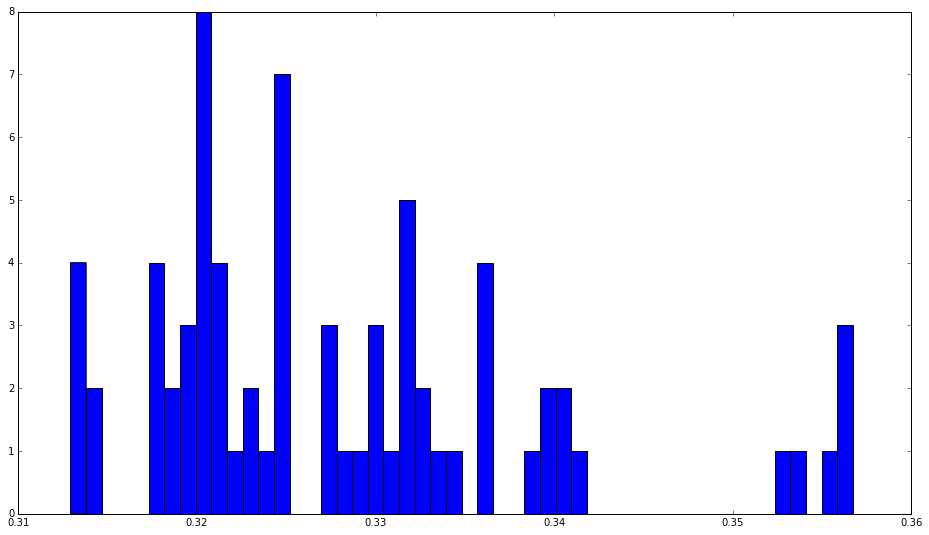

In [25]:
scores = [s.mean_validation_score for s in grid_search.grid_scores_]
plt.hist(scores, 50)

In [26]:
# take the best params and then do the iterative partial fit as before
lr = grid_search.best_estimator_
from scipy.stats import entropy
label_set = set(train['labels'])
lr_meta_results = []
# drnn = reset_drnn()
N = 500

valid_x = [sent[0].text for sent in valid['sents']]
valid_y = valid['labels']

# first N examples
small_train = {k:v[:N] for k,v in train.items()}
rest_train = {k:v[N:] for k,v in train.items()}

# fit until early_stop on limited training
meta_batch_num = 0
while len(small_train['labels']) < len(train['labels']):
    print("%"*80)
    print("%i labeled so far (meta_cycle: %i, N: %i)" % (len(small_train['labels']), meta_batch_num, N))
    print("%"*80)

    x_data = [sent[0].text for sent in small_train['sents']]
    y_data = small_train['labels']
    
    lr.fit(np.array(x_data), y_data)
    score = lr.score(np.array(valid_x), valid_y)
    lr_meta_results.append(score*100)

    # get all of the predictive distributions for the unknowns
    query_x = [sent[0].text for sent in rest_train['sents']]
#     query_y = rest_train['labels']
    dists = lr.predict_proba(np.array(query_x))

    # rank based on highest entropy
    # then turn back into rest_train.values() style
    ranked_train = zip(*sorted(zip(dists, *rest_train.values()), key=lambda x:entropy(x[0]), reverse=True))

    # if we're at the very end we may need to make N smaller
    if len(small_train['labels']) + N >= len(train['labels']):
            N = len(train['labels']) - len(small_train['labels']) 
            # this should be same as what's left of rest
            assert N == len(rest_train['labels']), "Hm..."
    # skim off top N unknowns to train with and leave the rest as before
    small_train = {k:list(v)+list(ranked_train[i+1])[:N] for i,(k,v) in enumerate(small_train.items())}
    rest_train = {k:list(ranked_train[i+1])[N:] for i,(k,v) in enumerate(small_train.items())}
    meta_batch_num += 1
print("Done...")
print(lr_meta_results)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
500 labeled so far (meta_cycle: 0, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1000 labeled so far (meta_cycle: 1, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1500 labeled so far (meta_cycle: 2, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
2000 labeled so far (meta_cycle: 3, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
2500 labeled so far (meta_cycle: 4, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

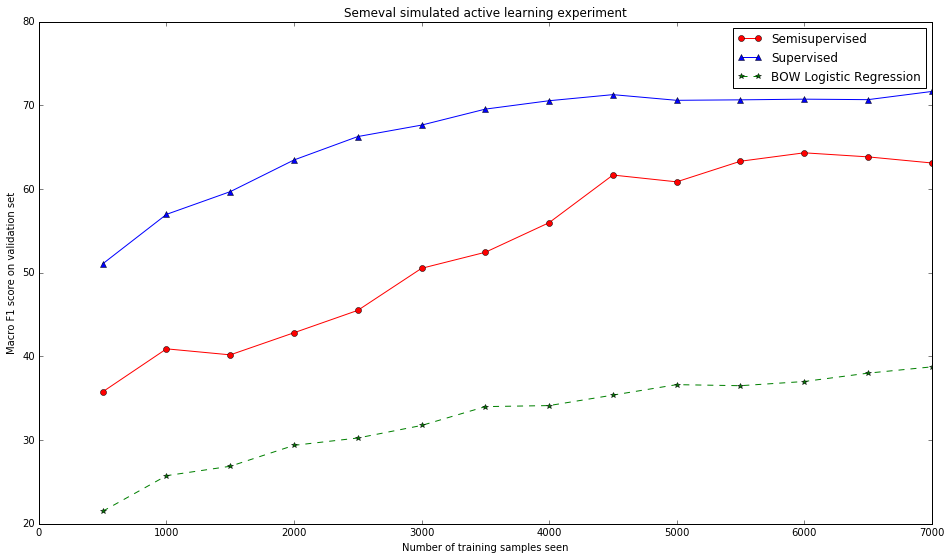

In [27]:
N=500
Ns = [N*i for i in range(1, len(unsup_f1s)+1)]
fix, ax = plt.subplots(1,1)
ax.plot(Ns, unsup_f1s, 'ro-', label="Semisupervised")
ax.plot(Ns, sup_f1s, 'b^-', label="Supervised")
ax.plot(Ns, lr_meta_results, 'g*--', label='BOW Logistic Regression')
# ax.set_xticks(Ns)
plt.legend(loc='best')
plt.title('Semeval simulated active learning experiment')
plt.xlabel('Number of training samples seen')
plt.ylabel('Macro F1 score on validation set')
plt.savefig('figures/active_learning_experiment.pdf')

In [249]:
def plot_dists(dists, labels, int2label):
    """Plot the predicted distributions as small multiples

    Args:
        dists: list of pmfs, all the same size
        int2label: dict of ints to labels for pmfs
    """
    fig, axarr = plt.subplots(len(dists)/2, 2, sharex=True, figsize=(16, len(dists)))
    xticks = range(len(int2label.keys()))
    for i, dist in enumerate(dists):
        pred = np.zeros_like(dist)
        pred[np.argmax(dist)] = np.max(dist)
        true = np.zeros_like(dist)
        true[labels[i]] = dist[labels[i]]
        axarr[i/2, i%2].stem(dist, 'bo-')
        axarr[i/2, i%2].stem(pred, 'ro-')
        axarr[i/2, i%2].stem(true, 'go-')

        axarr[i/2, i%2].set_xlim([-1,19])
        axarr[i/2, i%2].set_xticks(xticks)
#         if i % 3 == 0 and i:
        axarr[i/2, i%2].set_xticklabels(int2label.values(), rotation=45, horizontalalignment="right", x=-2)
        axarr[i/2, i%2].set_title("True(b): %s" % int2label[labels[i]])
        axarr[i/2, i%2].set_xlabel("Predicted(g): %s" % int2label[np.argmax(dist)])
    plt.tight_layout()

7189


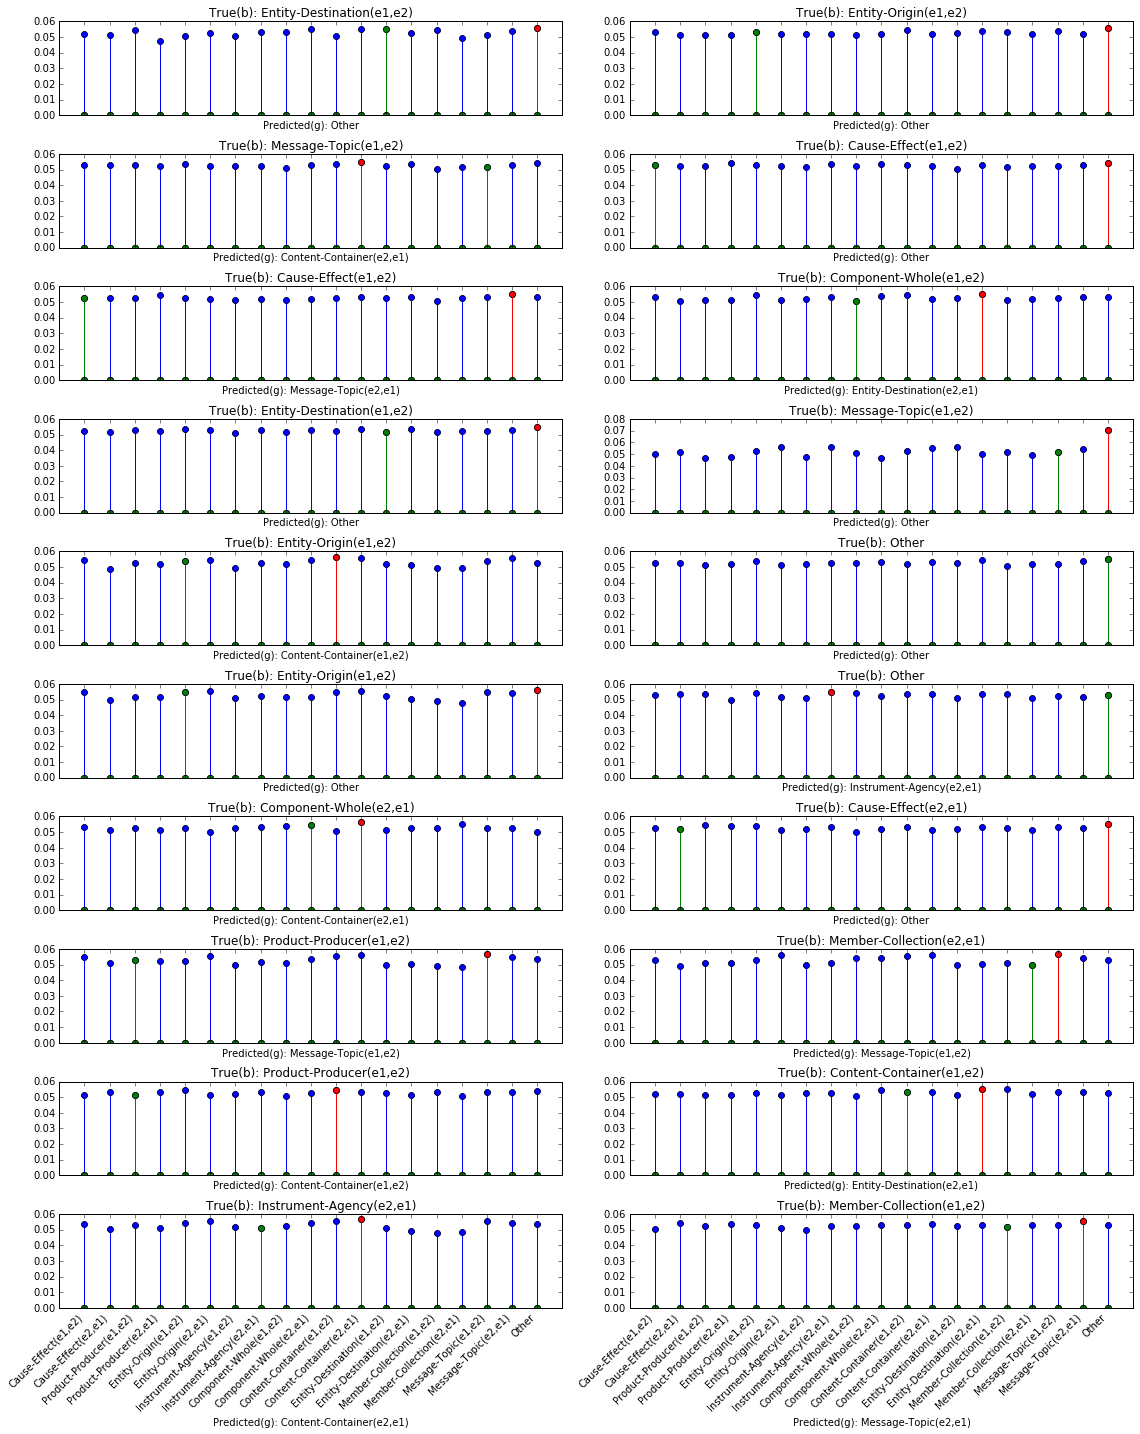

In [250]:
print(len(dists))
plot_dists(dists[:20], rest_train['labels'], int2label)

## No unsupervised

In [278]:
from scipy.stats import entropy
label_set = set(train['labels'])
sup_meta_results = []
drnn = reset_drnn()
N = 500
# first N examples
small_train = {k:v[:N] for k,v in train.items()}
rest_train = {k:v[N:] for k,v in train.items()}

# fit until early_stop on limited training
meta_batch_num = 0
while len(small_train['labels']) < len(train['labels']):
    print("%"*80)
    print("%i labeled so far (meta_cycle: %i, N: %i)" % (len(small_train['labels']), meta_batch_num, N))
    print("%"*80)

    drnn, results = alternating_fit(drnn, DH, small_train, valid, label_set, neg_per=20, unsup=False)
    sup_meta_results.append({'N':N, 'results':results})

    # get all of the predictive distributions for the unknowns
    query_batch = DH.classification_batch(len(rest_train['labels']),
                                          rest_train['sdps'], 
                                          rest_train['targets'],
                                          rest_train['labels'])
    _, dists = drnn.predict(query_batch[0], query_batch[1], query_batch[3], return_probs=True)

    # rank based on highest entropy
    # then turn back into rest_train.values() style
    ranked_train = zip(*sorted(zip(dists, *rest_train.values()), key=lambda x:entropy(x[0]), reverse=True))

    # if we're at the very end we may need to make N smaller
    if len(small_train['labels']) + N >= len(train['labels']):
            N = len(train['labels']) - len(small_train['labels']) 
            # this should be same as what's left of rest
            assert N == len(rest_train['labels']), "Hm..."
    # skim off top N unknowns to train with and leave the rest as before
    small_train = {k:list(v)+list(ranked_train[i+1])[:N] for i,(k,v) in enumerate(small_train.items())}
    rest_train = {k:list(ranked_train[i+1])[N:] for i,(k,v) in enumerate(small_train.items())}
    meta_batch_num += 1
print("Done...")

<DPNN: W:300, D:25, H:600, V:22683>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
500 labeled so far (meta_cycle: 0, N: 500)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++ CYCLE 0 +++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
********************************************************************************
*** CLASS EPOCH 0 ***
********************************************************************************
(0:0:0) s 0/10, e 0 avg class xent loss = 2.9534
(0:0:3) s 9/10, e 0 validation avg class xent loss = 2.5859
New Best!
Saving model to file: checkpoints/relembed_semeval_alt_hidden.ckpt-0-10
Saving model...
Saving model to file: checkpoints/relembed_semeval_alt_hidden.ckpt-0-10
Macro P: 18.8170, R: 15.2325, F1: 16.8361
****************************************************************************

In [284]:
sup_meta_results[0]['results'][0].keys()

['stats', 'cm', 'class_epoch', 'model', 'macro_f1', 'unsup_epoch', 'cycle']

## Looking at best and worst predictions for best SEMISUP mode

In [37]:
best = sorted(meta_results[-1]['results'], key=lambda x:x['macro_f1'], reverse=True)[0]
drnn.restore(best['model'])

In [40]:
# get all of the classification distributions over the validation set
query_batch = DH.classification_batch(len(valid['labels']),
                                          valid['sdps'], 
                                          valid['targets'],
                                          valid['labels'])
_, dists = drnn.predict(query_batch[0], query_batch[1], query_batch[3], return_probs=True)
# rank based on highest entropy
# then turn back into rest_train.values() style
ranked_valid = zip(*sorted(zip(dists, *valid.values()), key=lambda x:entropy(x[0]), reverse=True))
# print(ranked_valid)
ranked = {k:list(ranked_valid[i+1]) for i,(k,v) in enumerate(valid.items())}
ranked['dists'] = ranked_valid[0]

********************************************************************************
3323	"He stirred the oil, garlic and cumin seeds together in a <e1>dish</e1> large enough to hold the <e2>sardines</e2> in a single layer."

Comment:

dish large hold sardines


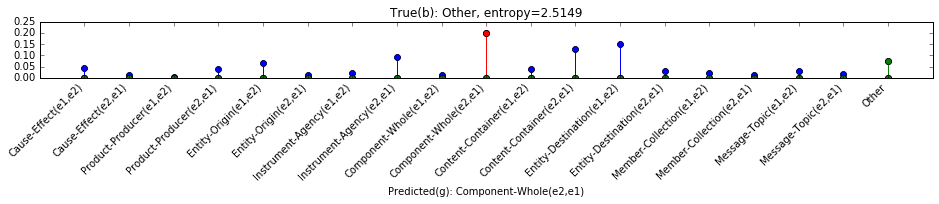

********************************************************************************
3970	"Old Kook's makes super strong <e1>shoe</e1> <e2>laces</e2>, designed especially for skateboarding."

Comment:

shoe laces


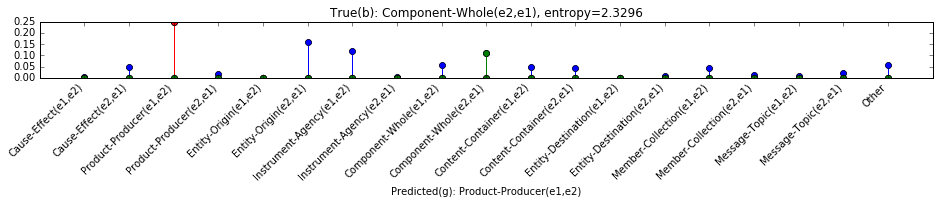

********************************************************************************
5608	"The <e1>housing</e1> encloses a double sealed ball <e2>bearing</e2>, with a lower lip seal for additional protection."

Comment:

housing encloses bearing


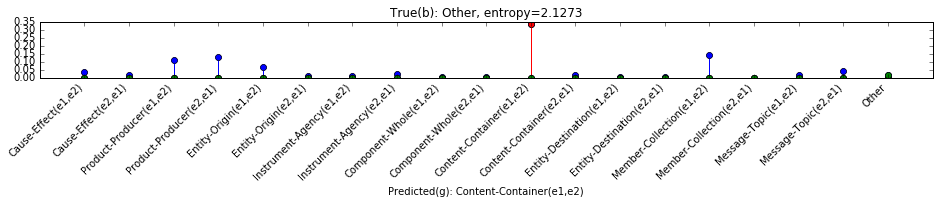

********************************************************************************
3644	"<e1>Light</e1> is composed of <e2>particles</e2> or corpuscles, which are refracted by accelerating into a denser medium."

Comment:

light composed of particles


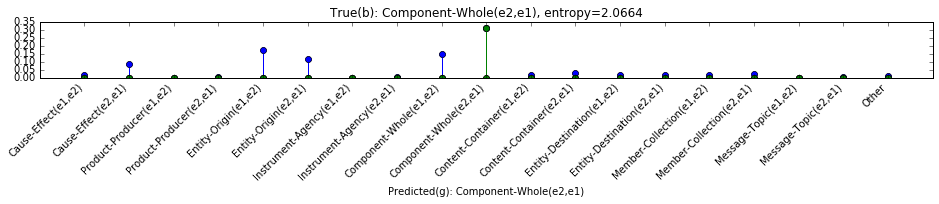

********************************************************************************
5641	"The morning session of the <e1>symposium</e1> ends with a reunion lunch for the <e2>attendees</e2>."

Comment:

symposium of session ends with lunch for attendees


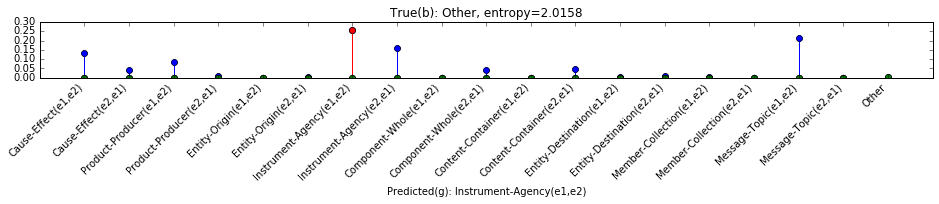

********************************************************************************
1575	"The <e1>input</e1> <e2>queue</e2> is used for processing events from an MFG/PRO application to a WebSphere-connected application."

Comment: Type.

input queue


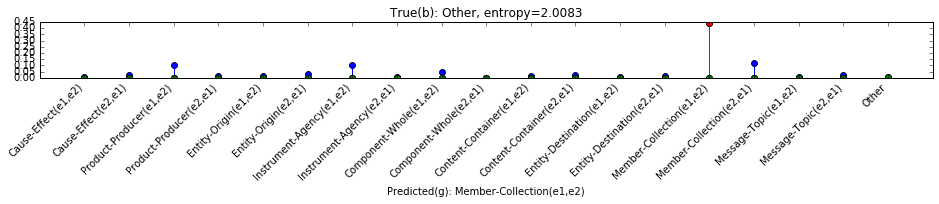

********************************************************************************
4439	"There was a time when the sound of an accordion playing in the <e1>cars</e1> of the <e2>metro</e2> brought commuters respite from "le stress.""

Comment:

cars of commuters brought metro


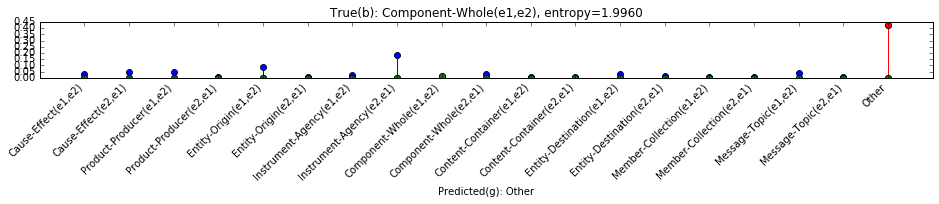

********************************************************************************
4158	"The first thought we had was to set up the <e1>bank</e1> of <e2>monitors</e2> and simply feed a bright and unusual color to it, such as green, and then use the greenscreened monitors to later add video of our choosing."

Comment:

bank of monitors


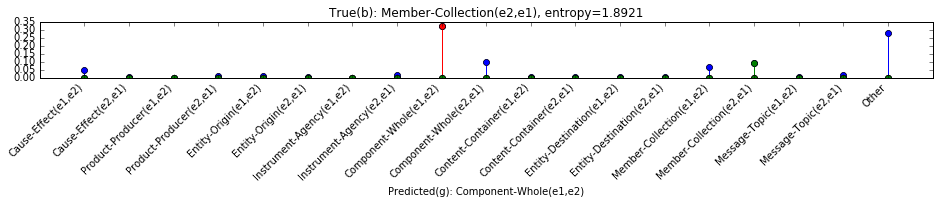

********************************************************************************
3021	"13, students were evacuated from Conrad Residence for approximately 15 minutes after <e1>burnt food</e1> in one of the kitchens set off the fire <e2>alarm</e2>."

Comment:

burnt food after minutes for evacuated set alarm


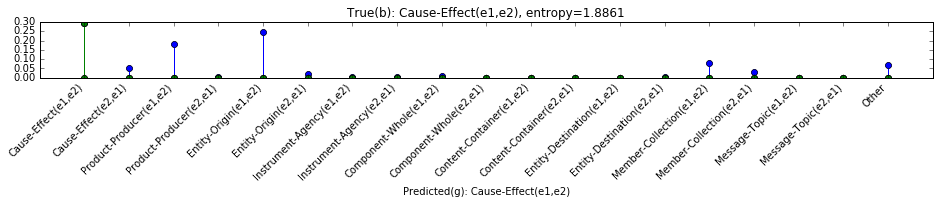

********************************************************************************
6424	"The project <e1>process</e1> is comprised of a <e2>field study</e2> with Istanbul inhabitants for 4 weeks and presentations to last 8 weeks."

Comment:

process comprised of study field


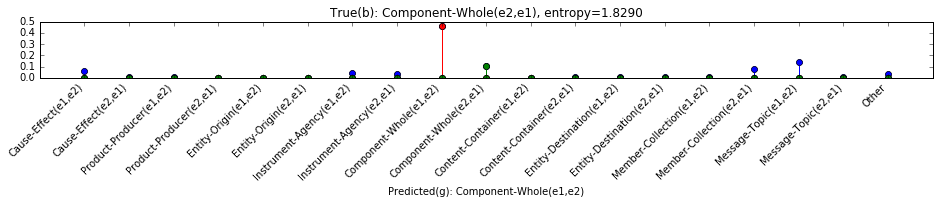

********************************************************************************
7848	"In addition to serving as a <e1>fertilizer</e1> <e2>ingredient</e2>, ammonia can also be used directly as a fertilizer by forming a solution with irrigation water, without additional chemical processing."

Comment: Difficult boundary, Component-Whole would be an alternative but it is implied that the ingredient is turned into fertilizer through "chemical processing"; the modality is outside the relation.

fertilizer ingredient


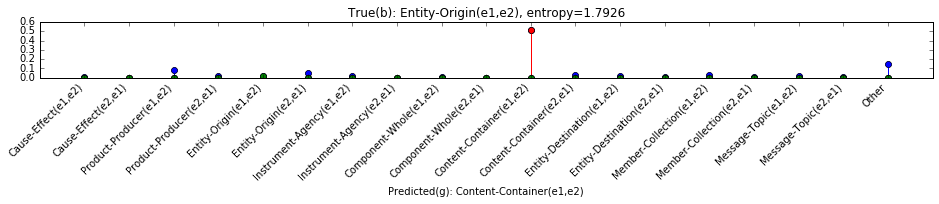

********************************************************************************
6495	"The new <e1>letter</e1> reminds them of the broker's <e2>prediction</e2> about ABC's stock and makes a new prediction about DEF's stock for the next month."

Comment:

letter reminds of prediction


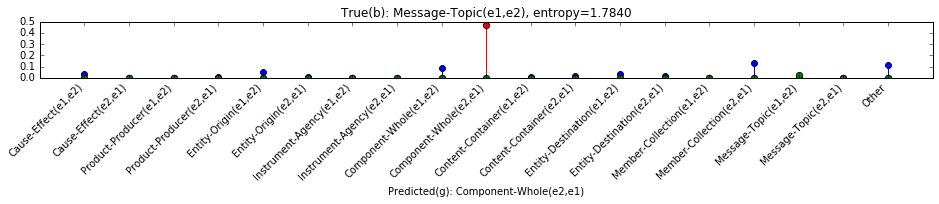

********************************************************************************
7310	"Furthermore, <e1>control</e1> over agricultural <e2>research</e2>, production, distribution and practice is shifting from public institutions to private corporations, which are profit driven and are not motivated by humanitarian concerns."

Comment:

control over research


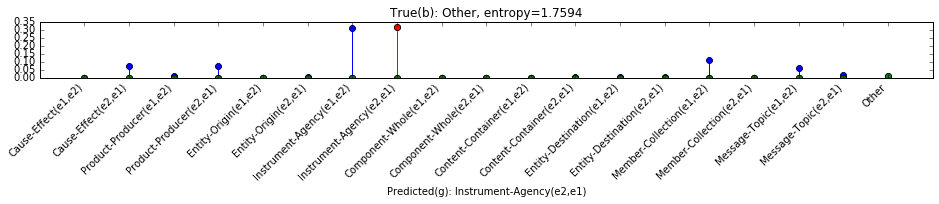

********************************************************************************
6890	"A <e1>trawl</e1> through ancient copies of the Herts Advertiser threw up a treasure <e2>trove</e2> of information about the early days of the city's first ever cinema."

Comment:

trawl threw trove


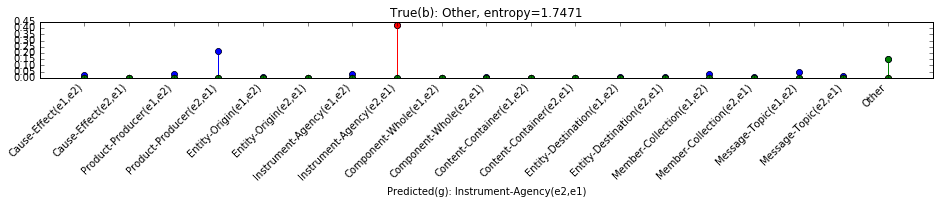

********************************************************************************
5646	"The primary parts of a <e1>skateboard</e1> are the <e2>deck</e2>, the trucks, the wheels and bearings, the hardware and the grip tape."

Comment:

skateboard of parts are deck


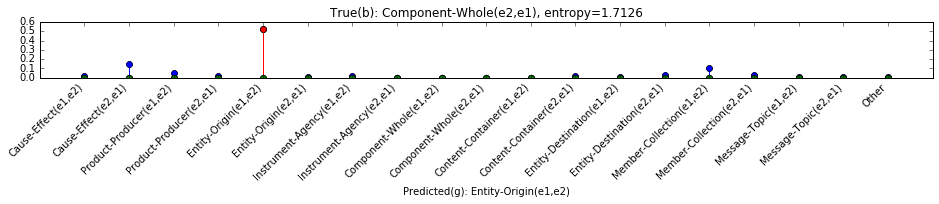

********************************************************************************
3449	"The three <e1>ship</e1> <e2>fleet</e2> of Columbus consisted of two ships known as caravels (Pinta and Nina) and a larger ship which served as Columbus's flag ship."

Comment: Another compound.

ship fleet


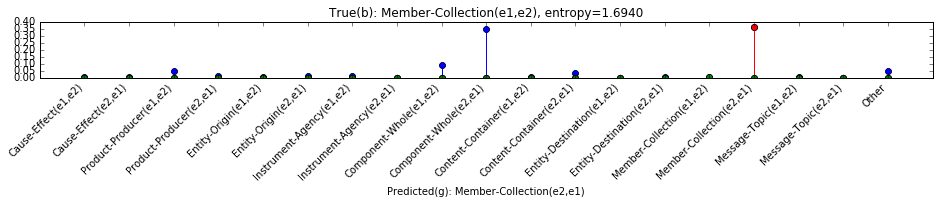

********************************************************************************
125	"This <e1>tradition</e1> has been narrated in prophet's early <e2>biographies</e2>."

Comment:

tradition narrated in biographies


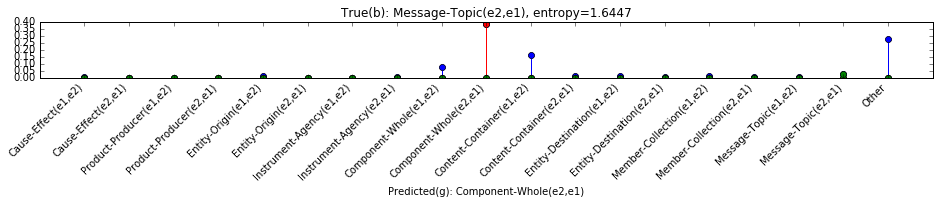

********************************************************************************
6992	"Brightly colored honey dipper beads and chunky disk <e1>rings</e1> make up this all wood foot <e2>toy</e2>."

Comment:

rings beads make toy


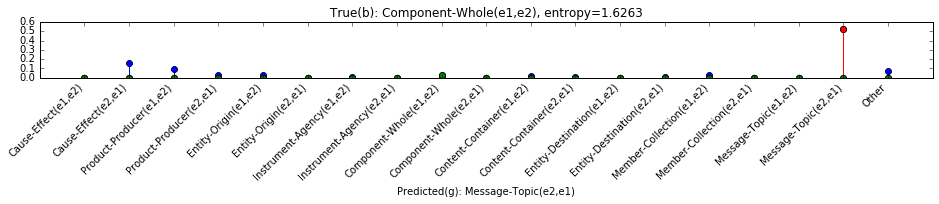

********************************************************************************
1563	"One aspect of the media <e1>presentation</e1> is the <e2>status</e2> attributed to claims-makers on either side of the issue."

Comment: presentation about status

presentation of aspect is status


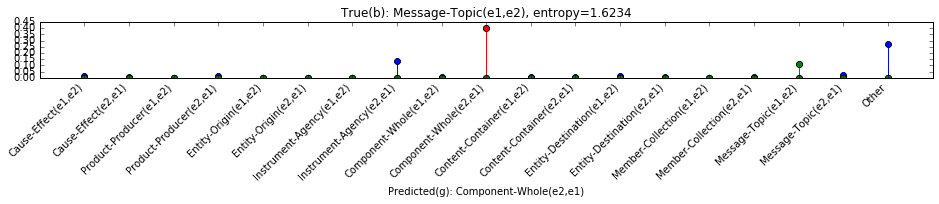

********************************************************************************
212	"Two of Walters's fingers are inside the <e1>koala</e1> 's <e2>pouch</e2>."

Comment:

koala pouch


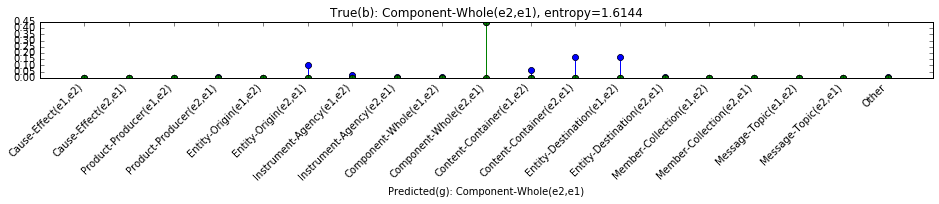

In [68]:
# look at the worst (top 20)
reload(eh)

k = 20
for i in range(k):
    print("*"*80)
    print(ranked['raws'][i])
    print(ranked['comments'][i])
    print(DH.sequence_to_sentence(ranked['sdps'][i]))
    eh.plot_dists([ranked['dists'][i]], [ranked['labels'][i]], int2label)
    plt.show()